## Probelm Definition

##### `Goal`: Predict whether a passenger survived the Titanic disaster (binary classification).
- Load, inspect, and understand a real-world dataset. 
- Identify and handle missing values and inconsistencies. 
- Perform basic data cleaning and feature engineering. 
- Conduct exploratory data analysis (EDA) with visualizations. 
- Build a simple model to demonstrate how the cleaned data can be used for prediction

##### `Business Value`: Such modeling mimics real-world survival analysis → can inform safety planning, risk prediction.

##### Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

- Features include:

    - PassengerId, Name, Age, Sex, Pclass (ticket class), Fare, Cabin, Embarked, SibSp, Parch, Survived (target).

##### Data Collection

In [38]:
# Load Dataset
train_df = pd.read_csv("dataset/train.csv")  
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
test_df = pd.read_csv("dataset/test.csv")  
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


- Data Description
    - Survived: 0 = No, 1 = Yes
    - pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
    - sibsp: # of siblings / spouses aboard the Titanic
    - parch: # of parents / children aboard the Titanic
    - ticket: Ticket number
    - cabin: Cabin number
    - embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

##### Data Inspection

In [40]:
# Datatype info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [41]:
# Statistical Summary
print("Shape:", train_df.shape)
train_df.describe()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [42]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [43]:
# Checking Missing data
def missing_data(df):
    missing_data = []
    for column_name, null_rows in train_df.isnull().sum().items():
        if null_rows > 0:
            perc = round(null_rows / len(train_df) * 100,2)
            missing_data.append([column_name, null_rows, perc])

    missing_df = pd.DataFrame(missing_data, columns=["Column", "Missing Values", "Percentage"])
    return missing_df

display("Train_df:",missing_data(train_df))
display("Test_df:",missing_data(test_df))

'Train_df:'

,Column,Missing Values,Percentage
0,Age,177,19.87
1,Cabin,687,77.10
2,Embarked,2,0.22


'Test_df:'

,Column,Missing Values,Percentage
0,Age,177,19.87
1,Cabin,687,77.10
2,Embarked,2,0.22


In [44]:
# Checking for Duplicates
display(f'Number of duplicated rows - train_df: {train_df.duplicated().sum(axis=0)}',f'Number of duplicated rows - test_df: {test_df.duplicated().sum(axis=0)}')

'Number of duplicated rows - train_df: 0'

'Number of duplicated rows - test_df: 0'

- Dataset contains 891 records with 12 columns
- Features include Passenger details (Name, Sex, Age, Fare, Pclass, etc.).
- Datatypes: mixture of numeric (int, float) and categorical (object).
- Missing values in Age, Cabin, and Embarked.

##### Data Preprocessing

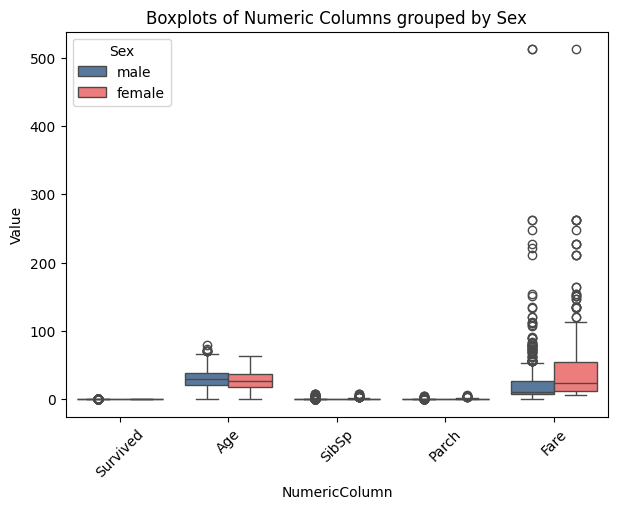

In [45]:
# outliers
cat_col = "Sex"

exclude_cols = ["PassengerId", "Pclass"]
num_cols = [col for col in train_df.select_dtypes(include="number").columns if col not in exclude_cols]
    
melted_df = train_df.melt(id_vars=cat_col, value_vars=num_cols, var_name="NumericColumn", value_name="Value").dropna()
custom_palette = {'male': '#4E79A7', 'female': '#FF6B6B'} 
plt.figure(figsize=(7, 5))
sns.boxplot(x="NumericColumn", y="Value", hue=cat_col, data=melted_df, palette=custom_palette)
plt.title(f"Boxplots of Numeric Columns grouped by {cat_col}")
plt.xticks(rotation=45)
plt.show()

In [46]:
# Handling Missing data
def data_imputaion(df):
    df["Age"] = SimpleImputer(strategy="median").fit_transform(df[["Age"]])
    df["Fare"] = SimpleImputer(strategy="median").fit_transform(df[["Fare"]])
    df["Embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["Embarked"]])[:,0]
    return df

train_df = data_imputaion(train_df)
test_df = data_imputaion(test_df)
# Checking missing data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

- Outliers found in Age and Fare column
- Data imputaion
    - Age, Fare &rarr; median since they are numeric and skewed.
    - Embarked &rarr; most frequent since only 2 values missing.

##### Feature Engineering

In [47]:
# Title Extraction from Name column
def replace_title(df):
    df["Title"] = df["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)
    df["Title"] = df["Title"].replace(['Lady', 'Countess', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 
                                                'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df["Title"] = df["Title"].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
    return df

train_df = replace_title(train_df)
test_df = replace_title(test_df)

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rare
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


In [48]:
# Family features (family size, alone indicator, age group, deck)
def add_feature(df):
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    df["AgeGroup"] = pd.cut(df["Age"], bins=[0, 12, 19, 59, 100], labels=["Child", "Teen", "Adult", "Senior"])
    df["FareBand"] = pd.qcut(df["Fare"], 4, labels=["Low", "Mid", "High", "Very High"])

    # Simplify Cabin → deck letter
    df["Deck"] = df["Cabin"].astype(str).str[0]
    df["Deck"] = df["Deck"].replace("n", "Unknown")
        
    return df
    
train_df = add_feature(train_df)
test_df = add_feature(test_df)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,AgeGroup,FareBand,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,Adult,Low,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,Adult,Very High,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,Adult,Mid,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,Adult,Very High,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,Adult,Mid,Unknown


- Title Extraction: passenger titles (Mr, Mrs, Miss, Master) from the Name column
- New Features:
    - FamilySize: captures group travel with siblings, spouse, parents and children.
    - IsAlone: binary indicator if the passenger was alone.
    - Grouped Age into categories (child, adult, senior)
    - Simplified Cabin by using only the first letter (deck)
- Cabin &rarr; dropped due to excessive missing values.

##### Exploratory Data Analysis (EDA)

In [49]:
# Gender percentage of Total Passengers
gender_df =pd.concat(
    [
        train_df["Sex"].value_counts(), 
        train_df["Sex"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    ], axis=1, keys=["Total", "Percentage"]).reset_index()
gender_df

,Sex,Total,Percentage
0,male,577,64.76%
1,female,314,35.24%


- Out of 891 total passengers on board
    - The majority of passengers were men 65% 
    - Female passengers were only 35%

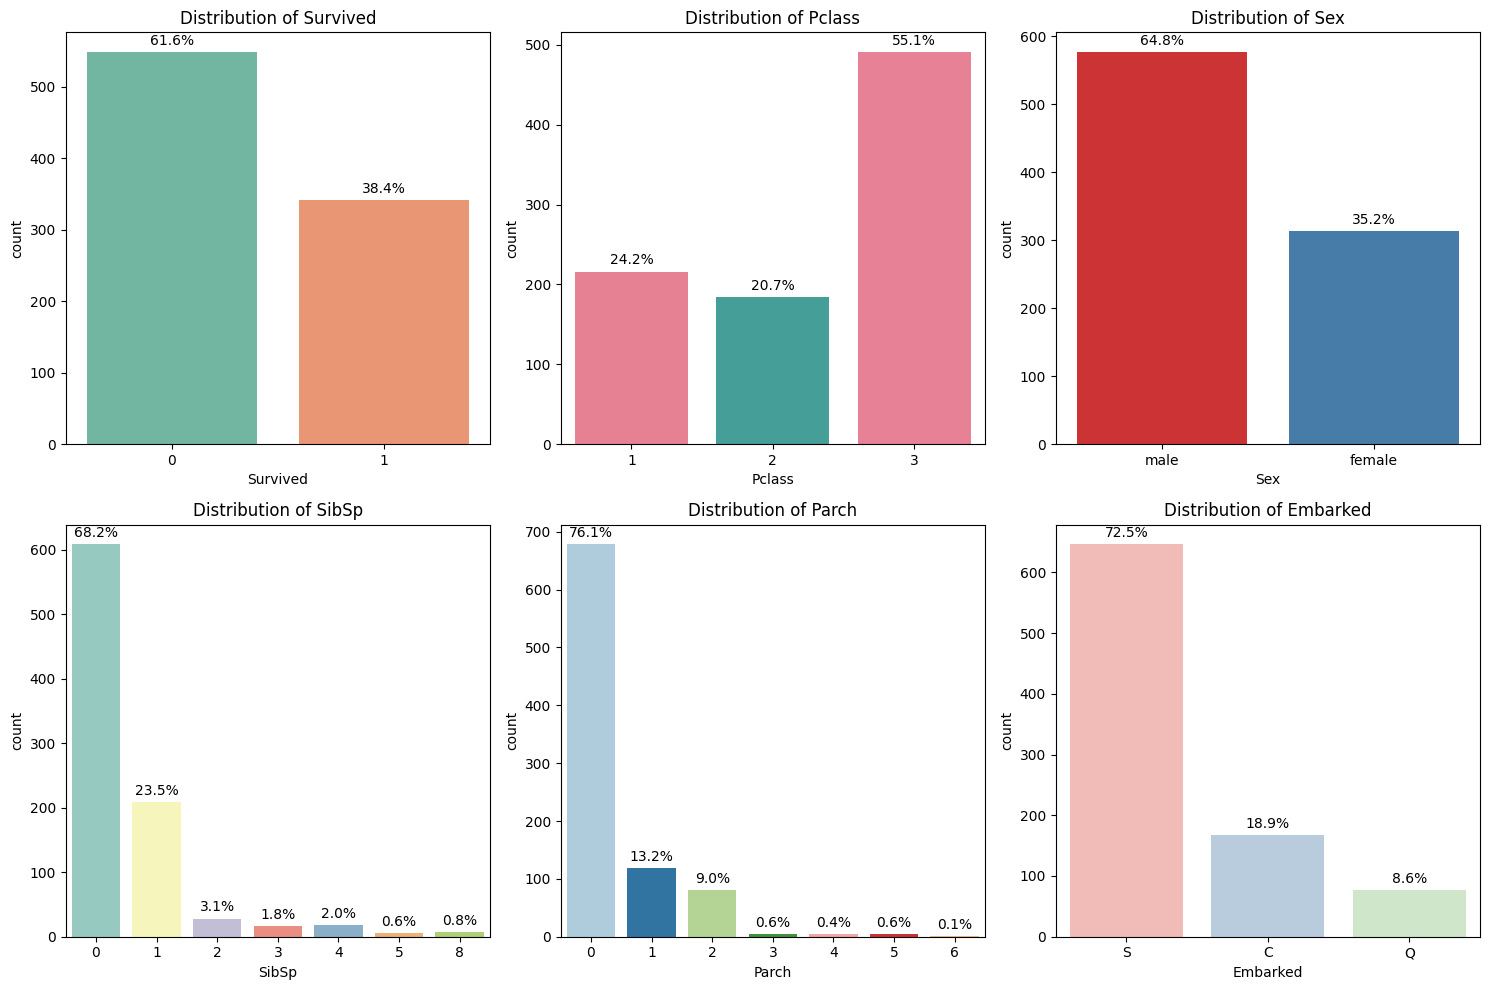

In [50]:
# Passenger distribution in each categories
categories = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]
palettes = ['Set2', 'husl', 'Set1', 'Set3', 'Paired', 'Pastel1']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten()

total = len(train_df)

for i, category in enumerate(categories):
    ax = sns.countplot(data=train_df, x=category, hue=category, palette=palettes[i], dodge=False, legend=False, ax=axes[i])
    ax.set_title(f"Distribution of {category}")
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = 100 * height / total
            ax.annotate(f'{percentage:.1f}%',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black',
                        xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

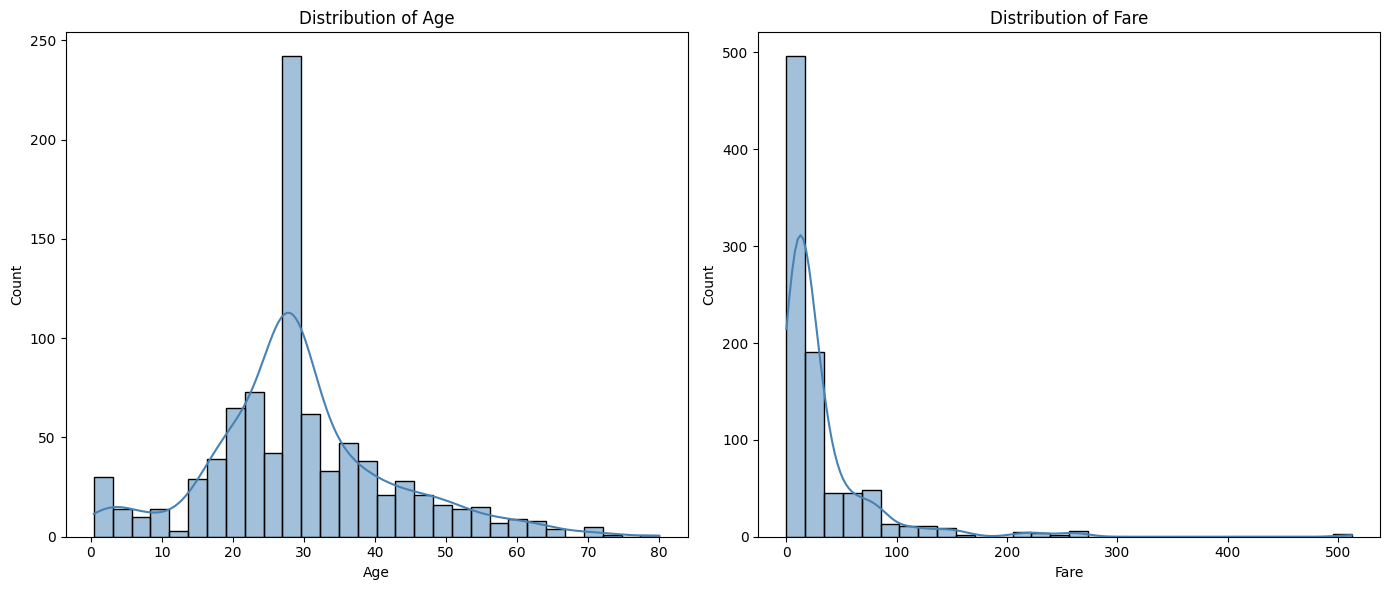

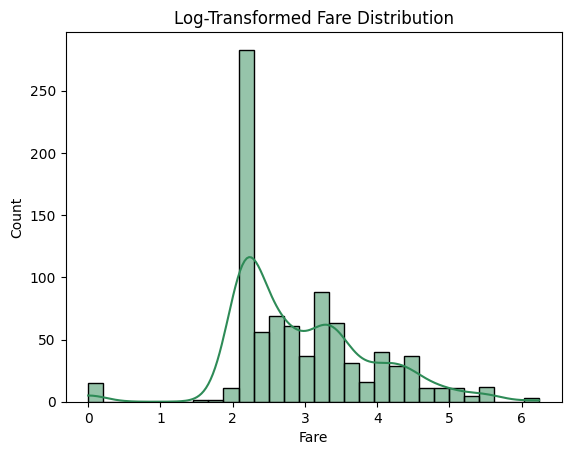

In [51]:
# Distribution of numerical attributes
numerical = ["Age", "Fare"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
total = len(train_df)

for i, num in enumerate(numerical):
    ax = sns.histplot(x=train_df[num], kde=True, bins=30, color="steelblue", ax=axes[i])
    ax.set_title(f"Distribution of {num}")

plt.tight_layout()
plt.show()

# log transformation for uniform data distribution of Fare

train_df['Fare'] = np.log(train_df['Fare']+1)
sns.histplot(x=train_df['Fare'], bins=30, kde=True, color='seagreen')

plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Log-Transformed Fare Distribution')
plt.show()

In [52]:
# Survival rate visualization
def visualize_survival_rate(plot_df, attr, ax, palette=None, title=None, labels=None):
    survived_df = plot_df[plot_df['Survived'] == 1]

    counts = survived_df[attr].value_counts()
    percentages = counts / counts.sum() * 100
    palette = sns.color_palette(palette, n_colors=len(counts))
    if labels is not None:
        counts.index = labels
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=counts.index,
        autopct=lambda p: f"{p:.2f}%",  
        startangle=90,
        colors=palette,
        wedgeprops={'width': 0.4} 
    )

    for text in autotexts:
        text.set_fontsize(10)

    ax.set_title(title)

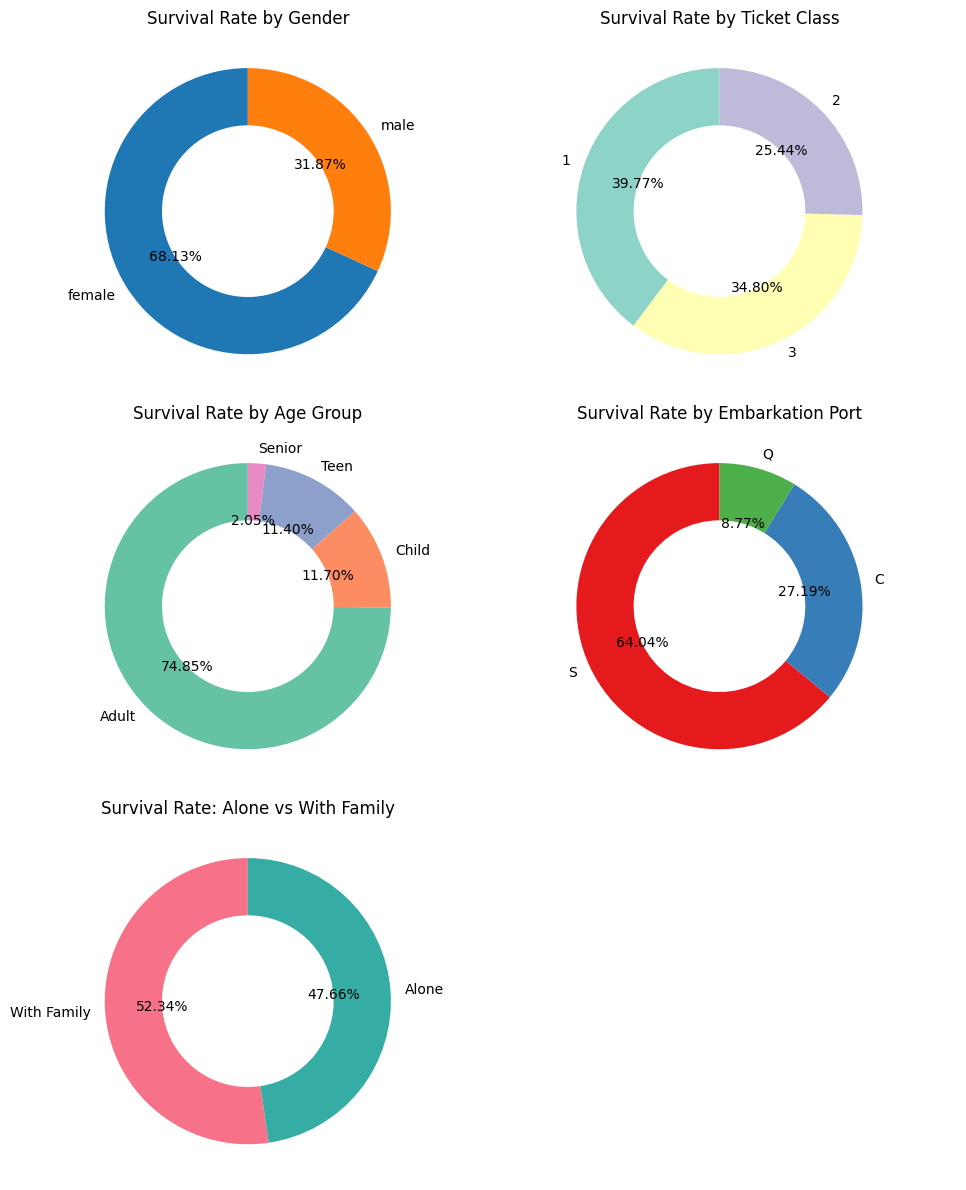

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

# Survival by Gender
visualize_survival_rate(train_df, attr="Sex", ax=axes[0], title="Survival Rate by Gender")

# Survival by Ticket Class
visualize_survival_rate(train_df, attr="Pclass", ax=axes[1], title="Survival Rate by Ticket Class", palette="Set3")

# Survival by Age Group
visualize_survival_rate(train_df, attr="AgeGroup", ax=axes[2], title="Survival Rate by Age Group", palette='Set2')

# Survival by Embarkation Port
visualize_survival_rate(train_df, attr="Embarked", ax=axes[3], title="Survival Rate by Embarkation Port", palette="Set1")

# Alone vs Family
train_df["IsAlone"] = (train_df["FamilySize"] == 1).astype(int)
visualize_survival_rate(train_df, attr="IsAlone", ax=axes[4], labels= ["With Family","Alone"], title="Survival Rate: Alone vs With Family", palette="husl")

# Hide the last empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

In [54]:
#  # Drop column
train_df = train_df.drop(columns=["Cabin", "Deck","IsAlone"])
test_df = test_df.drop(columns=["Cabin", "Deck","IsAlone"])

In [55]:
# Encode features

def encode_variables(df):
    # categorical features
    df["Sex"] = LabelEncoder().fit_transform(df["Sex"])
    df["Embarked"] = df["Embarked"].map({'S': 0, 'C': 1, 'Q': 2})

    # mapping
    title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    df["Title"] = df["Title"].map(title_mapping)

    age_mapping = {'Child': 0, 'Teen': 1, 'Adult': 2, 'Senior': 3}
    df["AgeGroup"] = df["AgeGroup"].map(age_mapping)

    fare_mapping = {'Low': 0, 'Mid': 1, 'High': 2, 'Very High': 3}
    df["FareBand"] = df["FareBand"].map(fare_mapping)

    df_model = df.drop(columns=["PassengerId", "Name", "Ticket", "SibSp", "Parch", "Age", "Fare"])
    return df_model


train_model_df = encode_variables(train_df)
test_model_df = encode_variables(test_df)

train_model_df.head()

,Survived,Pclass,Sex,Embarked,Title,FamilySize,AgeGroup,FareBand
0,0,3,1,0,0,2,2,0
1,1,1,0,1,2,2,2,3
2,1,3,0,0,1,1,2,1
3,1,1,0,0,2,2,2,3
4,0,3,1,0,0,1,2,1


In [56]:
# Save the final model-ready dataset
train_model_df.to_csv("dataset/titanic_model_ready.csv", index=False)
# Save the preprocessed test dataset
test_model_df.to_csv("dataset/titanic_test_ready.csv", index=False)

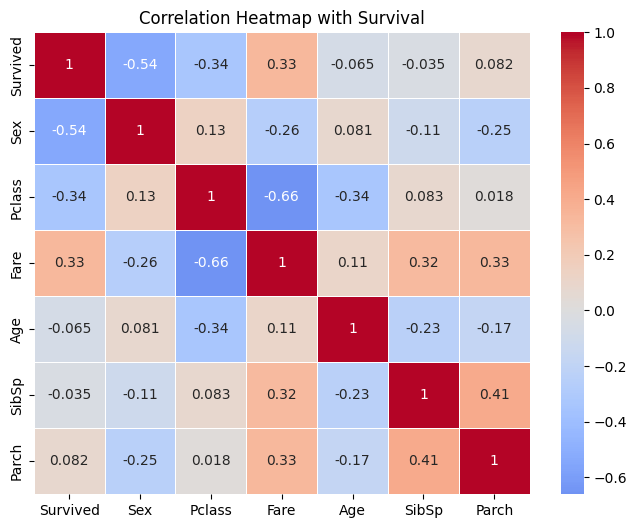

Correlation with survival:
 Survived    1.000000
Fare        0.329862
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64


In [57]:
# Correlation Heatmap
plt.figure(figsize=(8,6))

corr = train_df[["Survived", "Sex", "Pclass", "Fare", "Age", "SibSp", "Parch"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap with Survival")
plt.show()

surv_corr = corr["Survived"].sort_values(ascending=False)
print("Correlation with survival:\n", surv_corr)

- Survival by gender: Women survived more than men.
- Survival by class: Higher class → higher chance of survival.
- Age distribution: Children had better survival odds.
- Heatmap of correlations: Sex, Pclass, Fare strongly correlated with survival.
    - Sex &rarr; strong negative correlation (since male=1, female=0 → being male reduces survival chance).
    - Pclass &rarr; negative correlation (higher class → better survival).
    - Fare &rarr; positive correlation (wealthier passengers had better odds).
    - Other features (Age, SibSp, Parch) have weaker correlations

In [58]:
# Load the final model-ready dataset
train_model_df = pd.read_csv("dataset/titanic_model_ready.csv")

In [59]:
# Features & target
X = train_model_df.drop("Survived", axis=1)
y = train_model_df["Survived"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (712, 7) (712,)
Testing set shape: (179, 7) (179,)


##### Model Selection & Training

In [60]:
def model_selection(model_name, model):    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results = []
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([model_name, acc, prec, rec, f1])
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
    display(results_df)

    print(classification_report(y_test, y_pred))
    
    scores = cross_val_score(model, X_train, y_train, cv = 10)

    print('Using Cross Validation:')
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=["Died","Survived"], yticklabels=["Died","Survived"],cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Save the model
    pkl_filename = "models/titanic_"+model_name+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.787709,0.706667,0.768116,0.736111


              precision    recall  f1-score   support

           0       0.85      0.80      0.82       110
           1       0.71      0.77      0.74        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

Using Cross Validation:
0.79 accuracy with a standard deviation of 0.04


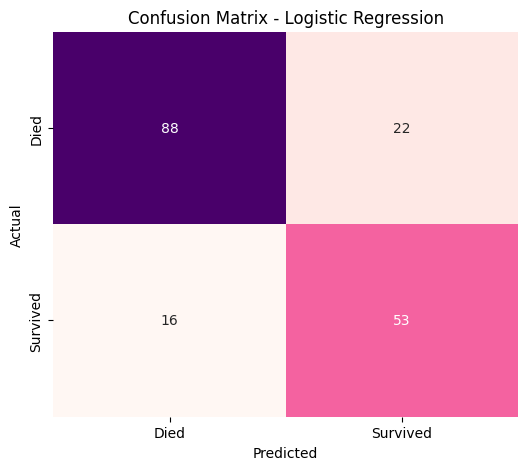

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.821229,0.877551,0.623188,0.728814


              precision    recall  f1-score   support

           0       0.80      0.95      0.87       110
           1       0.88      0.62      0.73        69

    accuracy                           0.82       179
   macro avg       0.84      0.78      0.80       179
weighted avg       0.83      0.82      0.81       179

Using Cross Validation:
0.84 accuracy with a standard deviation of 0.03


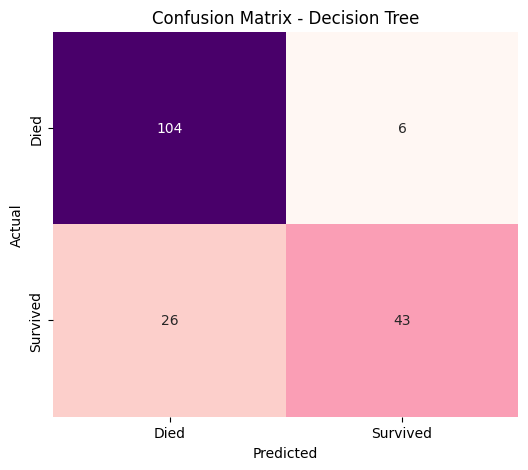

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.810056,0.807018,0.666667,0.730159


              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179

Using Cross Validation:
0.82 accuracy with a standard deviation of 0.04


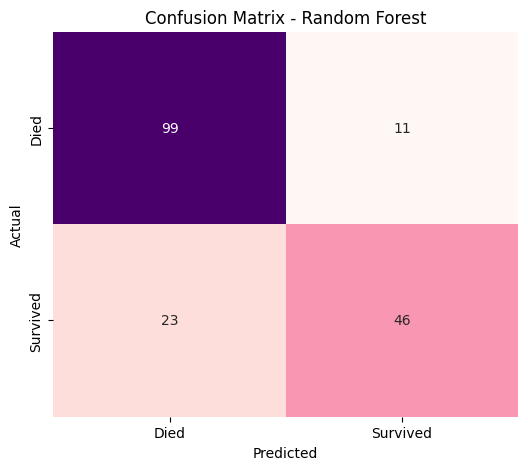

,Model,Accuracy,Precision,Recall,F1-Score
0,SVM,0.77095,0.725806,0.652174,0.687023


              precision    recall  f1-score   support

           0       0.79      0.85      0.82       110
           1       0.73      0.65      0.69        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.75       179
weighted avg       0.77      0.77      0.77       179

Using Cross Validation:
0.79 accuracy with a standard deviation of 0.04


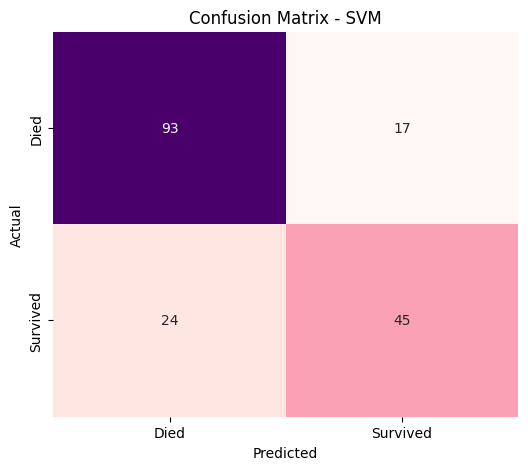

,Model,Accuracy,Precision,Recall,F1-Score
0,KNN,0.798883,0.789474,0.652174,0.714286


              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.65      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

Using Cross Validation:
0.83 accuracy with a standard deviation of 0.05


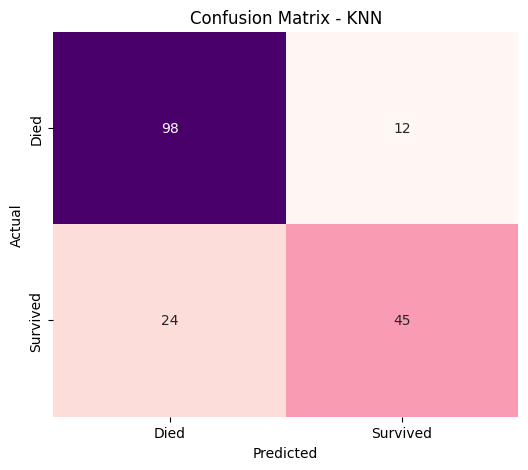

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.804469,0.793103,0.666667,0.724409


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Using Cross Validation:
0.81 accuracy with a standard deviation of 0.04


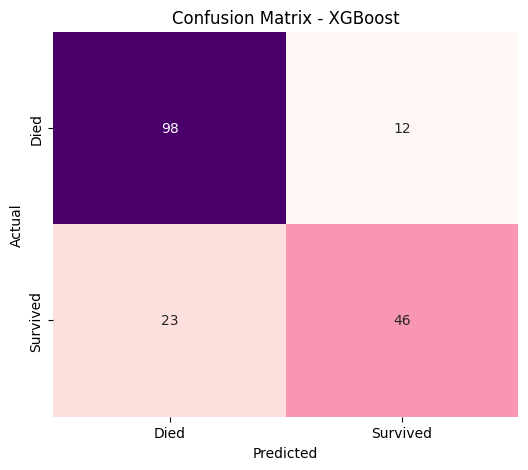

In [61]:
models = {
    'Logistic Regression': LogisticRegression(max_iter = 200,class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=10, random_state=42),
    'Random Forest' : RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42),
    'SVM' : SVC(kernel='linear', random_state=42),
    'KNN' : KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier( n_estimators=200, learning_rate=0.05, max_depth=5, use_label_encoder=False, random_state=42,eval_metric="logloss")
}
for name, model in models.items():      
    model_selection(name,model)

##### Model Evaluation

In [62]:
# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best Accuracy: 0.8287


In [63]:
# Train the optimized XGBoost model
xgb_optimized = XGBClassifier(
    colsample_bytree=0.8, 
    learning_rate=0.01, 
    max_depth=3, 
    n_estimators=200, 
    subsample=0.8, 
    random_state=42, 
    eval_metric='logloss'
)

xgb_optimized.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_optimized = xgb_optimized.predict(X_test)

# Evaluate the optimized model
accuracy_xgb_optimized = accuracy_score(y_test, y_pred_xgb_optimized)
print(f"Optimized XGBoost Accuracy: {accuracy_xgb_optimized:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_optimized))

Optimized XGBoost Accuracy: 0.8324

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



<Figure size 1000x800 with 0 Axes>

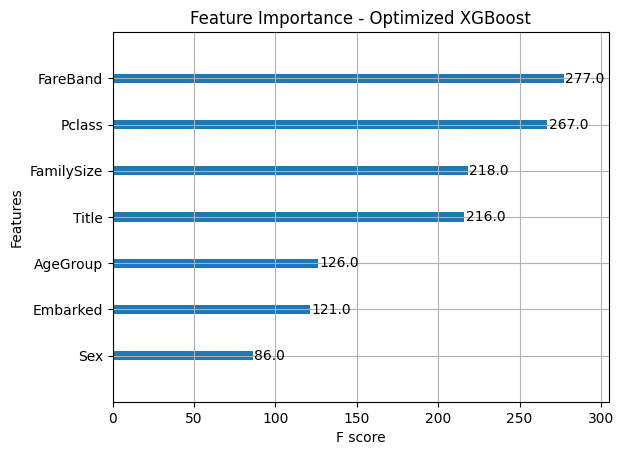

In [64]:
import xgboost as xgb

# Plot feature importance using the non-optimized XGBoost model
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_optimized, importance_type="weight", max_num_features=10)
plt.title("Feature Importance - Optimized XGBoost")
plt.show()

In [65]:
# Import joblib to save the model
import joblib

# Save the best non-optimized XGBoost model
joblib.dump(xgb_model, "models/best_xgboost_model.pkl")

print("Model saved as best_xgboost_model.pkl")

Model saved as best_xgboost_model.pkl


In [66]:
# Load the test dataset
test_model_df = pd.read_csv('dataset/titanic_test_ready.csv')

# Load saved best model
best_model = joblib.load("models/best_xgboost_model.pkl")

# Check if the model is loaded correctly
print("Model loaded successfully:", best_model)

Model loaded successfully: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [67]:
print("Test Data Shape:", test_model_df.shape)

Test Data Shape: (418, 7)


In [68]:
# Initialize and train the model
best_model = XGBClassifier(random_state=42, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Save the trained model correctly
joblib.dump(best_model, "models/best_xgboost_model.pkl")

print("Model retrained and saved correctly.")

Model retrained and saved correctly.


In [69]:
# Load the correctly saved model
best_model = joblib.load("models/best_xgboost_model.pkl")
print("Model loaded successfully after retraining.")

Model loaded successfully after retraining.


In [70]:
# Make predictions on the test set
predictions = best_model.predict(test_model_df)

# Add predictions to the original test DataFrame (for submission)
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": predictions})

# Save the submission file for Kaggle
submission.to_csv("dataset/titanic_predictions.csv", index=False)

print("Predictions saved as titanic_predictions.csv")

Predictions saved as titanic_predictions.csv


In [71]:
submission = pd.read_csv("dataset/titanic_predictions.csv")
print(submission.head())

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         0


### Inference

- The Titanic dataset contains demographic and ticket-related passenger information.
- Missing values were mainly in `Age`, `Embarked`, and `Cabin`. We imputed `Age` with the median, 
  `Embarked` with the mode, and dropped `Cabin` due to excessive missingness.
- Engineered features `FamilySize` and `IsAlone` added insights into group vs. solo travel.
- EDA revealed:
  - Women had much higher survival rates than men.
  - Children had much higher survival rates as given high priority under such events of ship sinking.
  - Higher passenger classes (1st class) had better survival chances.
  - Being alone decreased the chance of survival thus family size influenced survival.
- Logistic Regression achieved a reasonable accuracy (~78–82%), showing clear patterns in the data.
- Future improvements could include more sophisticated models (Random Forest, Gradient Boosting) 
  and tuning hyperparameters for higher accuracy.